# Cross Validation and confidence intervals
In this notebook we will practice cross-validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import r2_score

Get Auto data form here
https://www.kaggle.com/uciml/autompg-dataset

In [2]:
! pwd

/Users/yannetinterian/teaching/ML-lab/msds699/notebooks


In [3]:
! head auto-mpg.csv

In [4]:
df = pd.read_csv("auto-mpg.csv", na_values="?") # in this dataset "?" means NAs
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [5]:
df = df.iloc[:,[0,3]]
df.head()

,mpg,horsepower
0,18.0,130.0
1,15.0,165.0
2,18.0,150.0
3,16.0,150.0
4,17.0,140.0


In [6]:
df.shape

(398, 2)

In [7]:
# we are dropping rows with NAs
df = df.dropna() 
df.shape

(392, 2)

## Fit regression and polynomial regressions

In [8]:
df["horsepower^2"] = df["horsepower"]**2
df["horsepower^3"] = df["horsepower"]**3

In [9]:
df.head()

,mpg,horsepower,horsepower^2,horsepower^3
0,18.0,130.0,16900.0,2197000.0
1,15.0,165.0,27225.0,4492125.0
2,18.0,150.0,22500.0,3375000.0
3,16.0,150.0,22500.0,3375000.0
4,17.0,140.0,19600.0,2744000.0


In [10]:
Y = df.mpg.values

In [11]:
X = df.iloc[:,1:].values # ignore 0 column

In [12]:
X[0]

array([1.300e+02, 1.690e+04, 2.197e+06])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=15)

In [14]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [15]:
# regression fit mpg∼horsepower 

In [16]:
reg = LinearRegression().fit(X_train[:, 0].reshape(-1, 1), y_train)

In [17]:
# training and test scores
reg.score(X_train[:, 0].reshape(-1, 1),  y_train), reg.score(X_test[:, 0].reshape(-1, 1),  y_test)

(0.6201957965920296, 0.5570680987647478)

<AxesSubplot:>

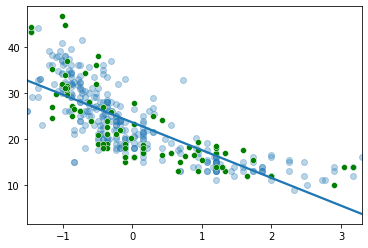

In [18]:
import seaborn as sns
sns.regplot(x=X_train[:, 0], y=y_train, ci=None, scatter_kws={'alpha':0.3})
sns.scatterplot(x=X_test[:, 0], y=y_test, color="green") # test set in green

In [19]:
# regression with horsepower and horsepower^2
reg = LinearRegression().fit(X_train[:, 0:2], y_train)
reg.score(X_train[:, 0:2],  y_train), reg.score(X_test[:, 0:2],  y_test)

(0.6903645830748442, 0.6750814474139647)

In [20]:
# regression with horsepower, horsepower^2, horsepower^3
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train,  y_train), reg.score(X_test,  y_test)

(0.6904267951606329, 0.6729482613896043)

## Leave-One-Out Cross-Validation

### without scaling

In [21]:
cv = LeaveOneOut()
y_pred = cross_val_predict(reg, X, Y, cv=cv) # note that we are not doing sacling here

In [22]:
r2_score(Y, y_pred)

0.681795380529385

### with scaling

In [23]:
# with scaling
kf = KFold(n_splits=Y.shape[0])
kf.get_n_splits(X)

392

In [24]:
pred = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train = Y[train_index]
    scaler = StandardScaler() # creates the scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    reg = LinearRegression().fit(X_train, y_train)
    pred.append(reg.predict(X_test))

In [25]:
r2_score(Y, pred)

0.6817953805293937

## K fold cross-validation

In [26]:
# this is the wrong way to do this
reg = LinearRegression()
scores = cross_val_score(reg, X, Y, cv=10, scoring="r2")
scores

array([ 0.53691175,  0.57102984,  0.29236569,  0.44699787,  0.43364399,
        0.7540499 ,  0.72886936,  0.5990077 , -0.45360827, -0.09046623])

In [27]:
np.mean(scores)

0.3818801601466527

In [28]:
# this is the right way
reg = LinearRegression()
y_pred = cross_val_predict(reg, X, Y, cv=10)
r2_score(Y, y_pred)

0.6494154103996537

In [29]:
# with scaling
kf = KFold(n_splits=10)
kf.get_n_splits(X)

10

In [30]:
pred = []
ys = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    scaler = StandardScaler() # creates the scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    reg = LinearRegression().fit(X_train, y_train)
    pred.append(reg.predict(X_test))
    ys.append(y_test)

In [31]:
r2_score(np.concatenate(ys), np.concatenate(pred))

0.6494154103996452

## Regularized regression (l2)

RidgeCV automatically finds the best hyper-parameters for regularized logistic regression (l2). In this case the only parameter is the regularization strength. 

In [32]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

### wrong way: without scaling

In [33]:
X = df.iloc[:,1:].values # ignore 0 column
Y = df.iloc[:,0].values
X.shape, Y.shape

((392, 3), (392,))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=15)
# cross-validation with the training set
clf = RidgeCV(cv=10).fit(x_train, y_train)

In [35]:
clf.alpha_

10.0

In [36]:
clf.score(x_test, y_test)

0.6726599101162211

### with scaling

In [37]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [38]:
clf = RidgeCV(cv=10).fit(X_train, y_train)
clf.alpha_

1.0

In [39]:
clf.score(X_test, y_test)

0.660881886411143

In [40]:
clf = Ridge(alpha=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.660881886411143

This is still not perfect. Why?

### more perfect but more complicated

In [41]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
kf.get_n_splits(x_train)

10

In [42]:
def score_given_alpha(alpha, kf, x, y):
    pred = []
    ys = []
    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]
        scaler = StandardScaler() # creates the scaler
        scaler.fit(x_train)
        X_train = scaler.transform(x_train)
        X_val = scaler.transform(x_val)
        reg = Ridge(alpha=alpha).fit(X_train, y_train)
        pred.append(reg.predict(X_val))
        ys.append(y_val)
    return r2_score(np.concatenate(ys), np.concatenate(pred))

In [43]:
def find_best_score(x_train, y_train, kf, alphas=[0.001, 0.01, 0.1, 1, 10, 100]):
    best_alpha = alphas[0]
    best_score = 0
    for alpha in alphas:
        score = score_given_alpha(alpha, kf, x_train, y_train)
        if score > best_score:
            best_score = score
            best_alpha = alpha
    return best_score, best_alpha

In [44]:
find_best_score(x_train, y_train, kf)

(0.6843695293097267, 0.1)

In [45]:
clf = Ridge(alpha=0.1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6681066936663369

## Confidence interval for test R^2 with repeated experiments

In [46]:
scores = []
for i in range(50):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    kf = KFold(n_splits=10, random_state=i, shuffle=True)
    kf.get_n_splits(x_train)
    score, alpha = find_best_score(x_train, y_train, kf)
    X_train = scaler.transform(x_train)
    X_test = scaler.transform(x_test)
    clf = Ridge(alpha=alpha).fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [47]:
np.array(scores)

array([0.7407839 , 0.6905541 , 0.67967151, 0.72126864, 0.74071826,
       0.65504518, 0.69262151, 0.73287117, 0.73250455, 0.72430372,
       0.69184116, 0.67152256, 0.69730023, 0.61736798, 0.7008765 ,
       0.66088189, 0.65945306, 0.69447111, 0.74037963, 0.7765761 ,
       0.73549901, 0.71357819, 0.66420463, 0.71677106, 0.64409213,
       0.65170896, 0.645958  , 0.70205727, 0.71993839, 0.68131084,
       0.63679194, 0.6718101 , 0.63165566, 0.67957018, 0.67995996,
       0.68981792, 0.68992973, 0.66404883, 0.7043583 , 0.72374475,
       0.71288116, 0.73005553, 0.63883997, 0.72255264, 0.75764418,
       0.67719152, 0.65791716, 0.61932661, 0.65486157, 0.66435989])

In [48]:
import scipy.stats as st
st.t.interval(alpha=0.95, df=len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)) 

(0.6794970283488466, 0.7006409245943639)

## Lab: 
Consider a model that predict mpg as a function of a polynomial regression of degree 6. Use Lasso to fit the best model. Use cross-validation to find the best regularization parameter.

What is the final formula? <p>
Which are the non-zero coefficients? <p>
Give a assesment of R^2 score with confidence intervals <p>
You are trying to find the best degree polynomial